# Practice 8
## Using clustering to detect attacks
As usual, let's start loading the data and the packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

def load_files(csv_file="",npy_file=""): return pd.read_csv(csv_file), np.load(npy_file, allow_pickle=True)

In [4]:
train_connections, train_embeddings = load_files(csv_file="train_connections.csv", npy_file="people_embeddings.npy")
print(train_embeddings.shape, train_connections.shape)
train_connections.head()

(300, 128) (24995, 5)


,logins,passwords,ips,dates,true_attempt
0,amare_finn@email.com,psswrd,185.75.78.21,21:03:41 19-09-2022,True
1,antonia_isaias@email.com,my_password,209.72.37.186,19:02:52 21-11-2020,True
2,yasmine_willa@email.com,1234567890,38.72.225.240,13:23:34 17-10-2023,True
3,jaheim_keily@email.com,ZJ$UvcR1wt,67.22.1.166,12:20:54 16-10-2020,True
4,itzel_janiel@email.com,IJANIE194,34.189.1.207,14:43:57 17-04-2021,True


## Guided example
Let's do see how that would works for dates and hours! 
### Get dates data list and labels list
staring with the train data, how can we represent dates as one number ?

In [50]:
def date_to_num(date):
    time = date.split(" ")[0]
    day = date.split(" ")[1]
    
    time = time.split(":")
    day = day.split("-")

    day = [int(i) for i in day]
    time = [int(i) for i in time]
    
    day = day[2] * 365 + day[1] * 30 + day[0]
    time = time[0] * 60 + time[1] + time[2] / 60

    return (day * 24 + time) * 60

    


In [51]:
dates = list(train_connections['dates']) # list of the ips, as strings: '255.255.255.255'
print(dates[0])
years = [int(date.split('-')[-1]) for date in dates]
print(f"The years range from {np.min(years)} to {np.max(years)}")

21:03:41 19-09-2022
The years range from 2019 to 2023


In [52]:
print(f"We can go from the str :'{dates[0]}' to a global number representing the total date from 2019 in seconds: {date_to_num(dates[0])}")
train_data = np.array([ date_to_num(date) for date in dates]) #now we have an array, composed of lists ['255','255','255','255']
train_data = train_data.astype(int) #we convert it to int as we want to deal with numbers here, which gives us something like [255, 255, 255, 255]
print(f"the shape of the train data is: {train_data.shape}")

We can go from the str :'21:03:41 19-09-2022' to a global number representing the total date from 2019 in seconds: 1063255181.0
the shape of the train data is: (24995,)


The time is a one dimensional information, so we can represent the distibution of the data as an histogram.

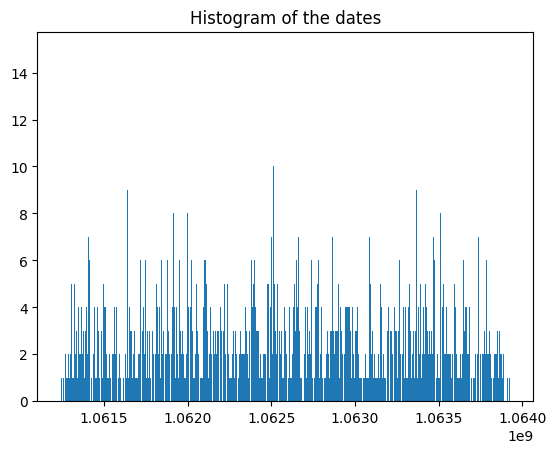

In [53]:
plt.hist(train_data, bins=10000)
plt.title("Histogram of the dates")
plt.show()


In [54]:
train_data_sorted = np.array(sorted(train_data))


Maybe there is something to do with grouping consecutive connections?

## Clustering the dates

In [55]:
cluster_labels = AgglomerativeClustering(distance_threshold=60*60, n_clusters=None).fit_predict(train_data.reshape(-1,1)) #finding which dates are in which cluster
# we don't chose the number of clusters, but if 2 samples are separated by more than 1hour, then it's a new group
print(f"Found {len(set(cluster_labels))} clusters of connections hapening in the same hour")

Found 1632 clusters of connections hapening in the same hour


In [56]:
len_clust = [] #number of elements per cluster
n_clusters = len(set(cluster_labels)) #how many clusters do we have
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    len_clust.append(len(clust_data)) #take the number of elements

len_set_clust = np.array(len_set_clust)

print(f"How many clusters with only one connection? {len(len_set_clust[len_set_clust==1])}/{n_clusters}")
print(f"Size of the 30 largest clusters: {sorted(len_clust, reverse=True)[:30]}") #print the size of the 30 largest clusters


How many clusters with only one connection? 0/1632
Size of the 30 largest clusters: [41, 40, 34, 34, 33, 33, 33, 32, 32, 31, 31, 31, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28]


In the largest clusters (len>10), do they have the same labels or not?

In [22]:
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    if len(clust_data)>10:
        print(f'For the cluster number {cluster}, the associated connections are: ')
        print(train_connections.iloc[cluster_labels==cluster])
        print("look messy, let's filter what we are printing")
        break

For the cluster number 0, the associated connections are: 
                           logins   passwords              ips  \
0            amare_finn@email.com      psswrd     185.75.78.21   
44         efraim_oumar@email.com        1234   34.188.119.158   
53        massimo_royal@email.com       a+lmq  213.185.117.140   
99          perla_sadie@email.com    PSADIE45   38.203.117.202   
138      sholom_vincent@email.com      ps$wrd   34.188.103.190   
...                           ...         ...              ...   
24820  vivienne_lizbeth@email.com  Sonny4Ever    63.219.177.68   
24821  vivienne_lizbeth@email.com    04112001    102.68.30.152   
24822  vivienne_lizbeth@email.com        0000   23.135.232.226   
24823  vivienne_lizbeth@email.com    07091962   72.252.107.127   
24824  vivienne_lizbeth@email.com  Viktor1961    172.97.85.164   

                     dates  true_attempt  
0      21:03:41 19-09-2022          True  
44     10:44:23 06-10-2022          True  
53     07:14:54 23-

In [23]:
for cluster in range(n_clusters):
    clust_data = train_data[cluster_labels==cluster]
    if len(clust_data)>10:
        print(f'For the cluster number {cluster}, the associated connections are: ')
        connections = train_connections.iloc[cluster_labels==cluster]
        for login in set(connections['logins']):
            if len(connections[connections['logins']==login])>1: #if there is more than one connection to this login, during the hour
                login_con = connections[connections['logins']==login]
                print(f"To the login {login}, {len(login_con)} connections detected, {100*len(login_con[login_con['true_attempt']])/len(login_con)}% which are true.")
                print(f"At the following dates: {list(login_con['dates'])}")
        print()


For the cluster number 0, the associated connections are: 
To the login karen_javier@email.com, 4 connections detected, 75.0% which are true.
At the following dates: ['06:41:40 21-10-2022', '18:57:51 22-09-2022', '18:57:44 22-09-2022', '18:57:37 22-09-2022']
To the login sholom_vincent@email.com, 2 connections detected, 100.0% which are true.
At the following dates: ['08:31:51 13-10-2022', '09:26:07 18-10-2022']
To the login karter_luke@email.com, 3 connections detected, 33.333333333333336% which are true.
At the following dates: ['17:04:23 10-09-2022', '13:02:50 24-09-2022', '02:33:07 17-10-2022']
To the login crystal_jenna@email.com, 2 connections detected, 0.0% which are true.
At the following dates: ['05:19:44 25-10-2022', '18:14:13 09-09-2022']
To the login vivienne_lizbeth@email.com, 9 connections detected, 0.0% which are true.
At the following dates: ['07:15:00 04-10-2022', '22:52:57 27-08-2022', '23:57:48 23-08-2022', '06:56:11 10-10-2022', '06:56:11 09-10-2022', '06:56:11 08-1

Looks like you just found a new attack scheme! do you think you could flag consecutive connections like that automatically?

## About the Ips
Then, we're gonna consider the ips. can we see clusters of ips, with similar behaviours?
### Get ip data list and labels list
staring with the train data

In [34]:
ips = list(train_connections['ips']) # list of the ips, as strings: '255.255.255.255'
print(ips)
print(f"We can go from the str :'{ips[0]}' to the list by splitting by the character '.': {ips[0].split('.')}")
train_data = [ip.split('.') for ip in ips]           #now we have an array, composed of lists ['255','255','255','255']
train_data = [[int(y) for y in x] for x in train_data]              #we convert it to int as we want to deal with numbers here, which gives us something like [255, 255, 255, 255]
train_data = np.array(train_data) #we convert it to a numpy array
print(f"the shape of the train data is: {train_data.shape}")

['185.75.78.21', '209.72.37.186', '38.72.225.240', '67.22.1.166', '34.189.1.207', '38.21.117.45', '158.62.151.233', '143.74.158.172', '40.98.38.20', '129.124.117.236', '34.7.176.87', '216.15.173.85', '158.85.93.151', '45.137.206.69', '38.231.149.60', '158.85.93.151', '38.217.179.171', '160.202.166.128', '4.200.112.38', '108.179.92.156', '64.124.200.229', '20.102.13.108', '205.248.46.145', '161.156.243.160', '104.254.165.178', '168.175.208.246', '150.190.217.144', '209.126.41.25', '38.82.92.49', '38.231.149.60', '144.203.193.254', '168.244.72.146', '20.20.48.116', '38.24.111.144', '213.188.79.75', '34.3.210.132', '23.247.243.160', '136.228.228.84', '52.112.11.147', '206.193.132.71', '23.45.28.114', '200.80.10.12', '34.188.119.158', '109.94.216.135', '34.188.119.158', '152.158.101.24', '188.93.137.210', '128.168.157.182', '66.198.105.161', '20.35.51.104', '68.155.21.201', '188.93.137.210', '188.74.128.227', '213.185.117.140', '38.197.185.43', '23.247.243.160', '192.112.255.205', '140.248

Then the labels

In [35]:
train_labels = np.array(train_connections['true_attempt']).astype(int) #we put the labels as int, so 0 or 1 because the values were either True of False
print(f"the shape of the train labels is: {train_labels.shape}. The label for True is {int(True)} and the label for False is {int(False)}")

the shape of the train labels is: (24995,). The label for True is 1 and the label for False is 0


### Representing the data using a t-SNE
Now we're gonna look at what it looks before and after clustering. Using a t-SNE! 

In [39]:

print(train_data)
tsne_data = TSNE(n_components=2).fit_transform(train_data) #tsne the data
print(tsne_data.shape)

[[185  75  78  21]
 [209  72  37 186]
 [ 38  72 225 240]
 ...
 [ 95 107 242 184]
 [ 95 107 242 184]
 [ 95 107 242 184]]
(24995, 2)


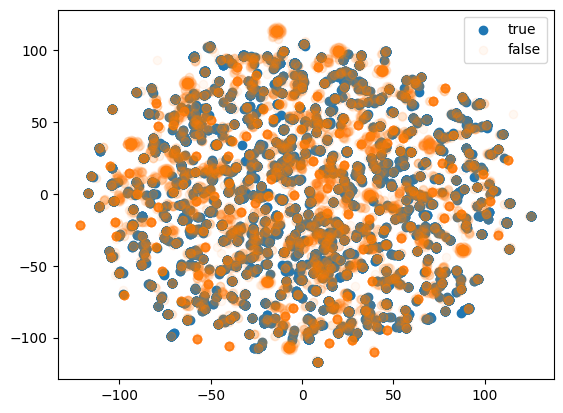

In [40]:
# let's use different colors to see what's hapening
trues, falses = tsne_data[train_labels==1], tsne_data[train_labels==0]
plt.scatter(trues[:,0], trues[:,1], label='true')
plt.scatter(falses[:,0], falses[:,1], label='false', alpha=0.05)
plt.legend()
plt.show()

### Clustering
We can see some of the embeddings are doing clusters of false attempts, meaning groups of ips should all be removed. how do we group them? with a clustering! 

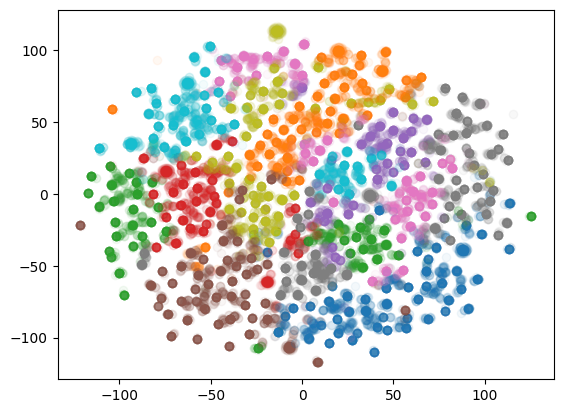

In [41]:
n_clusters = 20
cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(train_data) #finding which ips are in which cluster
for cluster in range(n_clusters):
    clust_data = tsne_data[cluster_labels==cluster]
    plt.scatter(clust_data[:,0], clust_data[:,1], alpha=0.05)
plt.show()

We need more clusters... but how much? There is a way to measure that: you can score a clustering to know how good it was, using the silhouette score.

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [03:29<00:00, 13.95s/it]


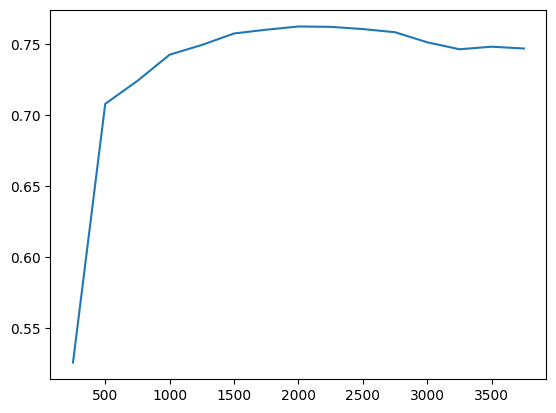

In [42]:
n_list = np.arange(250, 4000, 250) #from 250 to 4000 clusters
#n_list = np.arange(1950, 2050, 10) #arround 2000
silhouettes = []
for n_clusters in tqdm(n_list):
    cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(tsne_data) #finding which ips are in which cluster
    silhouettes.append(silhouette_score(tsne_data, cluster_labels))

plt.plot(n_list, silhouettes)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.42it/s]


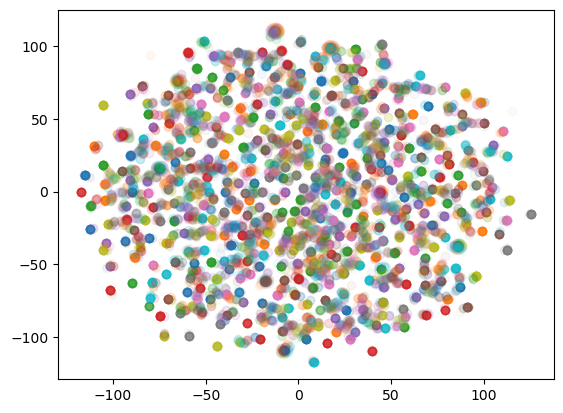

In [82]:
n_clusters = 2000
cluster_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(tsne_data) #finding which ips are in which cluster
for cluster in tqdm(range(n_clusters)):
    clust_data = tsne_data[cluster_labels==cluster]
    plt.scatter(clust_data[:,0], clust_data[:,1], alpha=0.05)
plt.show()

### Looking at the clusters
Let's look at the clusters we obtain. is there a trend in the proportion of good attempts in a given cluster?

In [83]:
len_clust = []
for cluster in tqdm(range(n_clusters)): #for each cluster
    clust_data = train_data[cluster_labels==cluster] #take the data from this cluster
    len_clust.append(len(clust_data))


print(f"What are the largest clusters? :{sorted(len_clust, reverse=True)[:30]}") #print the size of the 30 largest clusters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 11548.29it/s]

What are the largest clusters? :[51, 49, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44]


100%|██████████| 3750/3750 [00:01<00:00, 2080.11it/s]


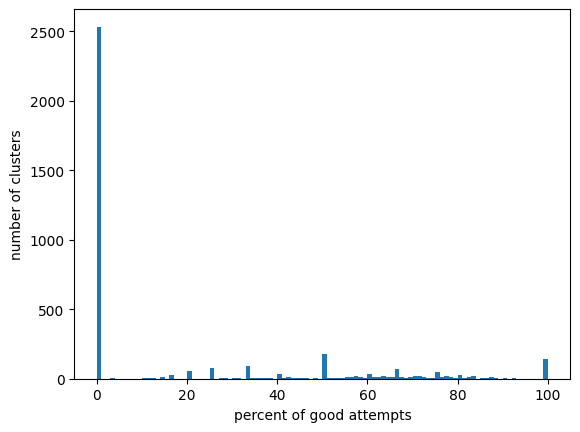

In [46]:
percent_good = []

for cluster in tqdm(range(n_clusters)): #for each cluster
    cluster_con = train_connections[cluster_labels==cluster] #take the data from this cluster
    percent_good.append(100*len(cluster_con[cluster_con['true_attempt']])/len(cluster_con))#save the % of good atempts
    
plt.hist(percent_good, bins=100)
plt.xlabel('percent of good attempts')  
plt.ylabel('number of clusters')
plt.show()



What can we guess from there?

In [ ]:
# We can guess that the clusters with a high % of good attempts are the ones with only one connection, and the ones with a low % of good attempts are the ones with a lot of connections